In [20]:
import numpy as np
import pandas as pd
import random
small = pd.read_csv("smallfaultmatrixplustime.txt")
small.rename(columns={small.columns[-1]: 'execution_time'}, inplace=True)
fault_coverage = small.iloc[:, 1:-1].sum(axis=1).tolist()  # Sum of 1s in test columns
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt

In [5]:
small 

,t0,0,0.1,0.2,0.3,0.4,0.5,1,0.6,0.7,execution_time
0,t1,0,0,0,0,0,0,1,0,0,2
1,t2,0,0,0,0,0,0,1,0,0,10
2,t3,0,0,0,0,0,0,1,0,0,9
3,t4,0,0,0,0,0,0,1,0,0,2
4,t5,0,0,0,0,0,0,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...
210,t211,0,0,1,0,0,0,1,0,0,6
211,t212,0,0,0,0,0,0,1,0,0,6
212,t213,0,0,0,0,0,0,1,0,0,3
213,t214,1,1,0,1,0,1,1,1,0,4


In [36]:
# Create the fitness function
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, 1.0))  # Minimize negative fault coverage, maximize execution time
creator.create("Individual", list, fitness=creator.FitnessMulti)




def evaluate(individual):
    selected_tests = [i for i, bit in enumerate(individual) if bit == 1]
    
    fault_coverage = sum(small['1'][i] for i in selected_tests)
    execution = sum(small['execution_time'][i] for i in selected_tests)
    fitness = (-fault_coverage, execution)  # Negative fault coverage for maximization
    return fitness
# Create the toolbox
toolbox = base.Toolbox()

# Register functions for individual creation, evaluation, etc.
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(small))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
population = toolbox.population(n=11)


hof = tools.HallOfFame(100)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std,  axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.8, mutpb=0.3, ngen=11, stats=stats, halloffame=hof, verbose=True)

pareto_front = tools.selNSGA2(population, len(population))



C:\Users\User\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\User\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg                        	std                      	min          	max        
0  	11    	[-96.81818182 583.54545455]	[ 7.23398773 42.55982663]	[-107.  492.]	[-79. 633.]
1  	4     	[-103.18181818  608.90909091]	[ 4.08585546 19.46771007]	[-107.  565.]	[-95. 625.]
2  	10    	[-106.18181818  620.36363636]	[ 2.28903242 18.47983042]	[-110.  577.]	[-102.  662.]
3  	8     	[-106.90909091  634.63636364]	[ 3.44975745 35.05910004]	[-112.  572.]	[-99. 691.]  
4  	10    	[-109.63636364  666.27272727]	[ 1.91988292 23.94345957]	[-113.  613.]	[-106.  711.]
5  	10    	[-111.36363636  691.        ]	[ 2.14360475 12.00757337]	[-116.  673.]	[-108.  711.]
6  	10    	[-113.27272727  700.81818182]	[ 3.83976583 22.98148734]	[-119.  659.]	[-105.  746.]
7  	10    	[-117.27272727  721.18181818]	[ 2.09288444 18.47267359]	[-120.  685.]	[-113.  746.]
8  	9     	[-118.          729.36363636]	[ 2.3741027  19.60645871]	[-121.  675.]	[-112.  746.]
9  	10    	[-120.36363636  742.18181818]	[ 3.36486464 10.169

Best random solution fitness: -91.0
Best GA solution fitness: -127.0


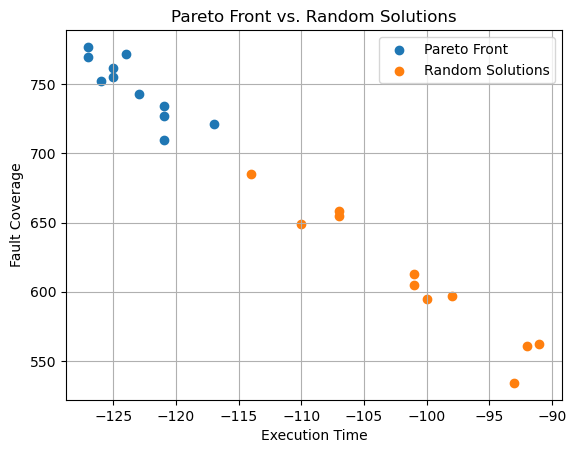

In [38]:

import random
import matplotlib.pyplot as plt

num_random_solutions = 11
random_solutions = [toolbox.individual() for _ in range(num_random_solutions)]

# Evaluate random solutions
for solution in random_solutions:
    solution.fitness.values = toolbox.evaluate(solution)
     
# Find the best random solution
best_random_solution = max(random_solutions, key=lambda x: x.fitness.values[0])

# Compare to the best GA solution
best_ga_solution = hof[0]

print("Best random solution fitness:", best_random_solution.fitness.values[0])
print("Best GA solution fitness:", best_ga_solution.fitness.values[0])

# Visualize the Pareto Front and Random Solutions
pareto_front = tools.selNSGA2(population, len(population))
pareto_x, pareto_y = zip(*[(ind.fitness.values[0], ind.fitness.values[1]) for ind in pareto_front])

random_x, random_y = zip(*[(ind.fitness.values[0], ind.fitness.values[1]) for ind in random_solutions])

plt.scatter(pareto_x, pareto_y, label="Pareto Front")
plt.scatter(random_x, random_y, label="Random Solutions")
plt.xlabel("Execution Time")
plt.ylabel( "Fault Coverage")
plt.title("Pareto Front vs. Random Solutions")
plt.legend()
plt.grid(True)
plt.show()